In [1]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Conv3D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import CSVLogger
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import seaborn as sns
from collections import deque
import copy

BATCH_SIZE = 2 #use for train only
EPOCHS = 1
NUMBER_TEST_SET = 10 #will do train/test split before this, and pass already-made sets in
TEMPORAL_LENGTH = 8 #use first 8 frames (these are 16 frames in each video)

In [2]:
def file_generator(data_path,data_files,temporal_stride=1,temporal_length=TEMPORAL_LENGTH):
    print(data_files)
    for f in data_files: 
        tmp_df = pd.read_csv(os.path.join(data_path,f), sep=',')
        label_list = list(tmp_df['label'])  
        total_images = len(label_list) 
        if total_images==temporal_length: 
            num_samples = int((total_images-temporal_length)/temporal_stride)+1
            print ('num of frames: {}: {}'.format(f,num_samples))
            img_list = list(tmp_df['FileName'])
        else: # if the number of frames < than temporal length , discard it
            print ('num of frames is less than temporal length; hence discarding this file-{}'.format(f))
            continue

        start_frame = 0
        samples = deque()  
        samp_count=0  
        for img in img_list:
            samples.append(img)
            if len(samples)==temporal_length: 
                samples_c=copy.deepcopy(samples) 
                samp_count+=1
                for t in range(temporal_stride): 
                    samples.popleft()
                yield samples_c,label_list[0]  

In [3]:
def load_samples(data_cat='train',temporal_stride=1,temporal_length=TEMPORAL_LENGTH):
    data_path = os.path.join('data_files',data_cat)
    data_files = os.listdir(data_path)
    #generator to read the samples
    file_gen = file_generator(data_path,data_files,temporal_stride,temporal_length)
    iterator = True
    data_list = []
    while iterator:
        try:
            x,y = next(file_gen)
            x=list(x)
            data_list.append([x,y])
        except Exception as e:
            print ('Exception: ',e)
            iterator = False
            print ('end of data generator')
    return data_list

In [4]:
train_data = load_samples(data_cat='train',temporal_stride=1,temporal_length=TEMPORAL_LENGTH)

['cluster1.csv', 'cluster0.csv', 'cluster2.csv', 'cluster3.csv', 'cluster7.csv', 'cluster6.csv', 'cluster4.csv', 'cluster5.csv', 'cluster8.csv', 'cluster9.csv']
num of frames: cluster1.csv: 1
num of frames: cluster0.csv: 1
num of frames: cluster2.csv: 1
num of frames: cluster3.csv: 1
num of frames: cluster7.csv: 1
num of frames: cluster6.csv: 1
num of frames: cluster4.csv: 1
num of frames: cluster5.csv: 1
num of frames: cluster8.csv: 1
num of frames: cluster9.csv: 1
Exception:  
end of data generator


In [5]:
test_data = load_samples(data_cat='test',temporal_stride=1,temporal_length=TEMPORAL_LENGTH)

['cluster1.csv', 'cluster0.csv', 'cluster2.csv', 'cluster3.csv', 'cluster7.csv', 'cluster6.csv', 'cluster4.csv', 'cluster5.csv', 'cluster8.csv', 'cluster9.csv']
num of frames: cluster1.csv: 1
num of frames: cluster0.csv: 1
num of frames: cluster2.csv: 1
num of frames: cluster3.csv: 1
num of frames: cluster7.csv: 1
num of frames: cluster6.csv: 1
num of frames: cluster4.csv: 1
num of frames: cluster5.csv: 1
num of frames: cluster8.csv: 1
num of frames: cluster9.csv: 1
Exception:  
end of data generator


In [6]:
print ('Total number of train samples:',len(train_data))

Total number of train samples: 10


In [7]:
train_data[0]

[['/Users/jieunyoo/april12_3dCNN/figures/cluster1/event000001_frame00.npy',
  '/Users/jieunyoo/april12_3dCNN/figures/cluster1/event000001_frame01.npy',
  '/Users/jieunyoo/april12_3dCNN/figures/cluster1/event000001_frame02.npy',
  '/Users/jieunyoo/april12_3dCNN/figures/cluster1/event000001_frame03.npy',
  '/Users/jieunyoo/april12_3dCNN/figures/cluster1/event000001_frame04.npy',
  '/Users/jieunyoo/april12_3dCNN/figures/cluster1/event000001_frame05.npy',
  '/Users/jieunyoo/april12_3dCNN/figures/cluster1/event000001_frame06.npy',
  '/Users/jieunyoo/april12_3dCNN/figures/cluster1/event000001_frame07.npy'],
 0.0143572918886504]

In [8]:
print ('Total number of test samples:',len(test_data))

Total number of test samples: 10


In [9]:
test_data[0]

[['/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame00.npy',
  '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame01.npy',
  '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame02.npy',
  '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame03.npy',
  '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame04.npy',
  '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame05.npy',
  '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame06.npy',
  '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame07.npy'],
 0.0412772962208331]

In [10]:
def shuffle_data(samples):
    data = shuffle(samples,random_state=2)
    return data

In [11]:
def data_generator(data,batch_size=BATCH_SIZE,temporal_padding='same',shuffle=True):               
    num_samples = len(data)
    if shuffle:
        data = shuffle_data(data)
    while True:   
        for offset in range(0, num_samples, batch_size):
            print ('starting index: ', offset) 
            batch_samples = data[offset:offset+batch_size]
            
            X_train = []
            y_train = []
            
            for batch_sample in batch_samples: 
                print(batch_sample)
                # Load image (X)
                x = batch_sample[0] #image
                y = batch_sample[1] #label
                temp_data_list = []
                for img in x:
                    try:
                        img = np.load(img)                        
                        temp_data_list.append(img)
                    except Exception as e:
                        print (e)
                        print ('error reading in frame: ',img)                      

                X_train.append(temp_data_list)
                y_train.append(y)

            X_train = np.array(X_train)   
            y_train = np.array(y_train)
            
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        
            print(X_train.shape)               
            yield X_train, y_train

In [12]:
print(len(train_data))
print(len(test_data))

train_generator = data_generator(train_data,batch_size=BATCH_SIZE,shuffle=True)

test_generator = data_generator(test_data,batch_size=1,shuffle=False) 
#x,y = next(train_generator)
#xx,yy = next(train_generator)

10
10


In [13]:
def get_model():
    model = Sequential()
    model.add(
    TimeDistributed(
        Conv2D(64, (3,3), activation='relu'), 
        input_shape=(8, 13, 21, 1))
    )
    model.add(
    TimeDistributed(
        Conv2D(64, (3,3), activation='relu')
        )
    )
    model.add(
    TimeDistributed(
        Flatten()
        )
    )        
    model.add(LSTM(1024, activation='relu', return_sequences=False))
    model.add(Dense(1024, activation='relu'))
    #model.add(Dropout(.01))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='Huber', optimizer=Adam(), metrics=['mean_squared_error'])
    model.summary()
    return model

model = get_model()


2022-04-18 13:36:24.915691: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 8, 11, 19, 64)    640       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 8, 9, 17, 64)     36928     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 8, 9792)          0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 1024)              44306432  
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                        

In [14]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))    

In [15]:
checkpoint_path = "cp.ckpt"
earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
csv_logger = CSVLogger('log.csv', append=True, separator=';')

In [16]:
#NUMBER_TEST = len(test_data)

#num_val_steps = int(NUMBER_TEST/BATCH_SIZE)

hist = model.fit(train_generator,
                 steps_per_epoch=(len(train_data)/BATCH_SIZE),
                 epochs=EPOCHS,
                 callbacks=[cp_callback, csv_logger, earlyStop_callback])

starting index:  0
[['/Users/jieunyoo/april12_3dCNN/figures/cluster7/event000007_frame00.npy', '/Users/jieunyoo/april12_3dCNN/figures/cluster7/event000007_frame01.npy', '/Users/jieunyoo/april12_3dCNN/figures/cluster7/event000007_frame02.npy', '/Users/jieunyoo/april12_3dCNN/figures/cluster7/event000007_frame03.npy', '/Users/jieunyoo/april12_3dCNN/figures/cluster7/event000007_frame04.npy', '/Users/jieunyoo/april12_3dCNN/figures/cluster7/event000007_frame05.npy', '/Users/jieunyoo/april12_3dCNN/figures/cluster7/event000007_frame06.npy', '/Users/jieunyoo/april12_3dCNN/figures/cluster7/event000007_frame07.npy'], -0.0172832196569843]
[['/Users/jieunyoo/april12_3dCNN/figures/cluster0/event000000_frame00.npy', '/Users/jieunyoo/april12_3dCNN/figures/cluster0/event000000_frame01.npy', '/Users/jieunyoo/april12_3dCNN/figures/cluster0/event000000_frame02.npy', '/Users/jieunyoo/april12_3dCNN/figures/cluster0/event000000_frame03.npy', '/Users/jieunyoo/april12_3dCNN/figures/cluster0/event000000_frame04

In [17]:
model.save_weights('myModel.h5')
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

In [18]:
#res = model.predict_generator(test_generator,NUMBER_SAMPLES)
#strangely, above line gives an extra sample (repeats one sample) 
#predict_generator is deprecated in favor of Model.predict, but Model.predict wasn't working, 
#so below, will just do. regular loop to get the predictions/true values

In [19]:
test_steps=NUMBER_TEST_SET 
truth = []
pred = []

for i in range(test_steps):
    x, y = next(test_generator)
    pred.append(model.predict(x))
    truth.append(y) 

pred = np.concatenate(pred)
truth = np.concatenate(truth)
print(len(truth))
print(len(pred))

df_predict = pd.DataFrame(pred, columns=['cotBeta'])
df_true = pd.DataFrame(truth, columns=['cotBeta'])
df_predict.to_csv('predictions.csv')
df_true.to_csv('trueLabels.csv')

starting index:  0
[['/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame00.npy', '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame01.npy', '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame02.npy', '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame03.npy', '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame04.npy', '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame05.npy', '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame06.npy', '/Users/jieunyoo/april12_3dCNN/figures-test/cluster1/event000001_frame07.npy'], 0.0412772962208331]
(1, 8, 13, 21)
starting index:  1
[['/Users/jieunyoo/april12_3dCNN/figures-test/cluster0/event000000_frame00.npy', '/Users/jieunyoo/april12_3dCNN/figures-test/cluster0/event000000_frame01.npy', '/Users/jieunyoo/april12_3dCNN/figures-test/cluster0/event000000_frame02.npy', '/Users/jieunyoo/april12_3dCNN/figures-test/cluster0/

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


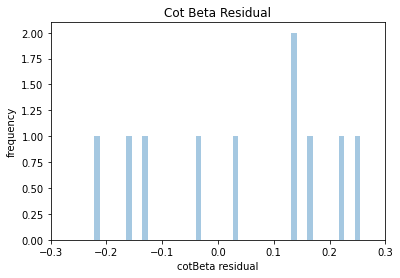

In [20]:
sns.distplot(df_true['cotBeta']-df_predict['cotBeta'], kde=False, bins=50)
plt.xlabel('cotBeta residual')
plt.ylabel('frequency')
plt.xlim([-.3,.3])
plt.title('Cot Beta Residual')
plt.savefig('cotBeta-resolution.png')